In [8]:
# ライブラリの導入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from biogeme.version import getText # なくても良い（バージョン確認のため導入）
from biogeme.biogeme import BIOGEME
from biogeme.database import Database
from biogeme.expressions import Beta, Variable, log, exp
from biogeme import models
from biogeme.models import loglogit
from biogeme.results_processing import get_pandas_estimated_parameters

In [9]:
# biogemeのバージョン確認
print(getText())

getText is deprecated; use get_text instead.


biogeme 3.3.1 [2025-12-14]
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



In [10]:
# マスターデータの読み込み
master_df = pd.read_csv("/home/shibumtk/B4research/estimate/data/01master_data/Logit_master5.csv", encoding="utf-8-sig")

# 欠損している部分をすべて0で補完（必要な処理は作成時にやってるから大丈夫）
master_df = master_df.fillna(0)

# 男性のみ抽出
male_df = master_df[master_df["sex"] == 1]
female_df = master_df[master_df["sex"] == 2]

# 確認
print(len(male_df))
print(len(female_df))
male_df.columns

32293
16842


Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation', 'NearestStation_code', 'near_area_syou',
       'near_area_kinrin', 'near_area_sum', 'near_area_syou500',
       'near_area_kinrin500', 'near_area_sum500', 'near_area_syou300',
       'near_area_kinrin300', 'near_area_sum300', 'near_o_area_syou',
       'near_o_area_kinrin', 'near_o_area_sum', 'near_o_area_syou500',
       'near_o_area_kinrin500', 'near_o_area_sum500', 'near_o_area_syou300',
       'near_o_area_kinrin300', 'near_o_area_sum300', 'WorkplaceStation',
       'WorkplaceStation_code', 'WP_area_syou', 'WP_area_kinrin',
       'WP_area_sum', 'WP_area_syou500', 'WP_area_kinrin500', 'WP_area_sum500',
       'WP_area_syou300', 'WP_area_kinrin300', 'WP_area_sum300',
       'WP_o_area_syou', 'WP_o_area_kinrin', 'WP_o_area_sum',
       'WP_o_are

In [11]:
# 文字列は除外する
drop_cols =['NearestStation', 'WorkplaceStation']
male_df = male_df.drop(columns=drop_cols)
female_df = female_df.drop(columns=drop_cols)
male_df.columns

Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation_code', 'near_area_syou', 'near_area_kinrin',
       'near_area_sum', 'near_area_syou500', 'near_area_kinrin500',
       'near_area_sum500', 'near_area_syou300', 'near_area_kinrin300',
       'near_area_sum300', 'near_o_area_syou', 'near_o_area_kinrin',
       'near_o_area_sum', 'near_o_area_syou500', 'near_o_area_kinrin500',
       'near_o_area_sum500', 'near_o_area_syou300', 'near_o_area_kinrin300',
       'near_o_area_sum300', 'WorkplaceStation_code', 'WP_area_syou',
       'WP_area_kinrin', 'WP_area_sum', 'WP_area_syou500', 'WP_area_kinrin500',
       'WP_area_sum500', 'WP_area_syou300', 'WP_area_kinrin300',
       'WP_area_sum300', 'WP_o_area_syou', 'WP_o_area_kinrin', 'WP_o_area_sum',
       'WP_o_area_syou500', 'WP_o_area_kinrin500', 'WP_o_area

In [12]:
male_df[['MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdMembers(all)', 'WorkTime[m]', 'near_area_syou300']].describe()

,MainlineTime[m],AccessTime_used[m],HouseholdMembers(all),WorkTime[m],near_area_syou300
count,32293.000000,32293.000000,32293.000000,32293.000000,3.229300e+04
mean,59.184716,11.005194,2.776391,617.937788,4.370758e+05
std,26.287945,6.851415,1.210711,110.074010,4.515083e+05
min,0.000000,0.000000,1.000000,240.000000,0.000000e+00
25%,41.006531,6.254512,2.000000,560.000000,0.000000e+00
50%,55.317570,9.671174,3.000000,600.000000,3.216042e+05
75%,74.859766,14.253896,4.000000,680.000000,6.878829e+05
max,295.442829,196.340577,9.000000,1200.000000,2.981425e+06


In [13]:
# biogeme.databaseに格納
m_master_db = Database("PTdata", male_df)

In [14]:
# 変数（main の DB）
PRITRIP   = Variable("PriTrip")                 # 目的変数（0/1）
MACM_min  = Variable("MainlineTime[m]")         # 本線（分）
WORK_min  = Variable("WorkTime[m]")             # 就業（分）
HHM       = Variable("HouseholdMembers(all)")   # 世帯人数
LU        = Variable("near_area_syou")          # 駅土地利用指標
AT_min    = Variable("AccessTime_used[m]")      # その日の実際の端末時間（分）
MODE      = Variable("first_transportation")    # 1:歩, 2:自転車, 4:バス, 5:車

# スケーリング
MACM_h = m_master_db.define_variable("MACM_h",  MACM_min / 60)   # /時
WORK_h = m_master_db.define_variable("WORK_h",  WORK_min / 60)   # /時
LU_s   = m_master_db.define_variable("LU_s",    LU / 1000000) # 1,000,000㎡あたり
AT_c   = m_master_db.define_variable("AT_c",    AT_min - np.mean(male_df["AccessTime_used[m]"])) 

# 各モード利用可否
WALK_AV    = Variable("walk_av")
BICYCLE_AV = Variable("bicycle_av")
BUS_AV     = Variable("bus_av")
CAR_AV     = Variable("car_av")

# モード・ダミー（歩=基準なので作らない）
D_BIC = m_master_db.define_variable("D_BIC", (MODE == 2))
D_BUS = m_master_db.define_variable("D_BUS", (MODE == 4))
D_CAR = m_master_db.define_variable("D_CAR", (MODE == 5))
D_WAL = m_master_db.define_variable("D_WAL", (MODE == 1)) # 交差項用に使う

# 交差項：端末時間 × モード（4本）
#AT_WAL = master_db.define_variable("AT_WAL", AT_c * D_WAL)
#AT_BIC = master_db.define_variable("AT_BIC", AT_c * D_BIC)
#AT_BUS = master_db.define_variable("AT_BUS", AT_c * D_BUS)
#AT_CAR = master_db.define_variable("AT_CAR", AT_c * D_CAR)

AT_WAL = m_master_db.define_variable("AT_WAL", AT_min * D_WAL)
AT_BIC = m_master_db.define_variable("AT_BIC", AT_min * D_BIC)
AT_BUS = m_master_db.define_variable("AT_BUS", AT_min * D_BUS)
AT_CAR = m_master_db.define_variable("AT_CAR", AT_min * D_CAR)

# 係数
ASC_YES  = Beta("ASC_YES", 0.0, None, None, 0)
B_MACM   = Beta("B_MACMTIME", -0.01, None, None, 0)  # /時
B_WORK   = Beta("B_WORKTIME", -0.30, None, None, 0)  # /時
B_HH     = Beta("B_HHM_all",  0.0, None, None, 0)
B_LU     = Beta("B_N_EKI_SCORE", 0.0, None, None, 0) # 駅土地利用を入れるなら

# モード・ダミー（歩が基準）→ 定数のずれ
B_D_BIC  = Beta("B_D_BICYCLE", 0.0, None, None, 0)
B_D_BUS  = Beta("B_D_BUS",     0.0, None, None, 0)
B_D_CAR  = Beta("B_D_CAR",     0.0, None, None, 0)

# 端末時間のモード別傾き（/分）
B_AT_WAL = Beta("B_AT_WALK",    -0.01, None, None, 0)
B_AT_BIC = Beta("B_AT_BICYCLE", -0.01, None, None, 0)
B_AT_BUS = Beta("B_AT_BUS",     -0.01, None, None, 0)
B_AT_CAR = Beta("B_AT_CAR",     -0.01, None, None, 0)

In [15]:
# 効用（V_NO=0 を基準に）
V_YES = (ASC_YES
         + B_MACM * MACM_h
         + B_WORK * WORK_h
         + B_HH   * HHM
         + B_LU * LU_s   # 利用駅土地利用指標
         + B_D_BIC * D_BIC + B_D_BUS * D_BUS + B_D_CAR * D_CAR
         + B_AT_WAL * AT_WAL + B_AT_BIC * AT_BIC + B_AT_BUS * AT_BUS + B_AT_CAR * AT_CAR)

V = {0: 0, 1: V_YES}

# モデルの推定と結果の表示
# 尤度関数の設定
logprob = loglogit(V, None, PRITRIP)

bio_m = BIOGEME(m_master_db, logprob, 
              generate_html=False, generate_yaml=False) # 推定結果保存可否
bio_m.model_name = "binlogit_mode_dummy_male"
bio_m.calculate_null_loglikelihood(avail={0:1, 1:1})
res_male = bio_m.estimate()
print(res_male.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results_male = get_pandas_estimated_parameters(estimation_results=res_male)
print(pandas_results_male)

Results for model binlogit_mode_dummy_male
Nbr of parameters:		12
Sample size:			32293
Excluded data:			0
Null log likelihood:		-22383.8
Final log likelihood:		-11168.14
Likelihood ratio test (null):		22431.33
Rho square (null):			0.501
Rho bar square (null):			0.501
Akaike Information Criterion:	22360.28
Bayesian Information Criterion:	22460.87

             Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0         ASC_YES  4.142515         0.115715       35.799173        0.000000
1      B_MACMTIME -0.417288         0.043986       -9.486905        0.000000
2      B_WORKTIME -0.506241         0.010344      -48.942380        0.000000
3       B_HHM_all -0.199905         0.015935      -12.545240        0.000000
4   B_N_EKI_SCORE  0.019943         0.007164        2.783742        0.005374
5     B_D_BICYCLE  0.001831         0.114040        0.016057        0.987189
6         B_D_BUS -0.068878         0.201573       -0.341702        0.732575
7         B_D_CAR -0.273325        

In [16]:
# biogeme.databaseに格納
f_master_db = Database("PTdata", female_df)

In [17]:
# 変数（main の DB）
PRITRIP   = Variable("PriTrip")                 # 目的変数（0/1）
MACM_min  = Variable("MainlineTime[m]")         # 本線（分）
WORK_min  = Variable("WorkTime[m]")             # 就業（分）
HHM       = Variable("HouseholdMembers(all)")   # 世帯人数
LU        = Variable("near_area_syou")          # 駅土地利用指標
AT_min    = Variable("AccessTime_used[m]")      # その日の実際の端末時間（分）
MODE      = Variable("first_transportation")    # 1:歩, 2:自転車, 4:バス, 5:車

# スケーリング
MACM_h = f_master_db.define_variable("MACM_h",  MACM_min / 60)   # /時
WORK_h = f_master_db.define_variable("WORK_h",  WORK_min / 60)   # /時
LU_s   = f_master_db.define_variable("LU_s",    LU / 1000000) # 1,000,000㎡あたり
AT_c   = f_master_db.define_variable("AT_c",    AT_min - np.mean(female_df["AccessTime_used[m]"])) 

# 各モード利用可否
WALK_AV    = Variable("walk_av")
BICYCLE_AV = Variable("bicycle_av")
BUS_AV     = Variable("bus_av")
CAR_AV     = Variable("car_av")

# モード・ダミー（歩=基準なので作らない）
D_BIC = f_master_db.define_variable("D_BIC", (MODE == 2))
D_BUS = f_master_db.define_variable("D_BUS", (MODE == 4))
D_CAR = f_master_db.define_variable("D_CAR", (MODE == 5))
D_WAL = f_master_db.define_variable("D_WAL", (MODE == 1)) # 交差項用に使う

# 交差項：端末時間 × モード（4本）
#AT_WAL = master_db.define_variable("AT_WAL", AT_c * D_WAL)
#AT_BIC = master_db.define_variable("AT_BIC", AT_c * D_BIC)
#AT_BUS = master_db.define_variable("AT_BUS", AT_c * D_BUS)
#AT_CAR = master_db.define_variable("AT_CAR", AT_c * D_CAR)

AT_WAL = f_master_db.define_variable("AT_WAL", AT_min * D_WAL)
AT_BIC = f_master_db.define_variable("AT_BIC", AT_min * D_BIC)
AT_BUS = f_master_db.define_variable("AT_BUS", AT_min * D_BUS)
AT_CAR = f_master_db.define_variable("AT_CAR", AT_min * D_CAR)

# 係数
ASC_YES  = Beta("ASC_YES", 0.0, None, None, 0)
B_MACM   = Beta("B_MACMTIME", -0.01, None, None, 0)  # /時
B_WORK   = Beta("B_WORKTIME", -0.30, None, None, 0)  # /時
B_HH     = Beta("B_HHM_all",  0.0, None, None, 0)
B_LU     = Beta("B_N_EKI_SCORE", 0.0, None, None, 0) # 駅土地利用を入れるなら

# モード・ダミー（歩が基準）→ 定数のずれ
B_D_BIC  = Beta("B_D_BICYCLE", 0.0, None, None, 0)
B_D_BUS  = Beta("B_D_BUS",     0.0, None, None, 0)
B_D_CAR  = Beta("B_D_CAR",     0.0, None, None, 0)

# 端末時間のモード別傾き（/分）
B_AT_WAL = Beta("B_AT_WALK",    -0.01, None, None, 0)
B_AT_BIC = Beta("B_AT_BICYCLE", -0.01, None, None, 0)
B_AT_BUS = Beta("B_AT_BUS",     -0.01, None, None, 0)
B_AT_CAR = Beta("B_AT_CAR",     -0.01, None, None, 0)

In [18]:
# 効用（V_NO=0 を基準に）
V_YES = (ASC_YES
         + B_MACM * MACM_h
         + B_WORK * WORK_h
         + B_HH   * HHM
         + B_LU * LU_s   # 利用駅土地利用指標
         + B_D_BIC * D_BIC + B_D_BUS * D_BUS + B_D_CAR * D_CAR
         + B_AT_WAL * AT_WAL + B_AT_BIC * AT_BIC + B_AT_BUS * AT_BUS + B_AT_CAR * AT_CAR)

V = {0: 0, 1: V_YES}

# モデルの推定と結果の表示
# 尤度関数の設定
logprob = loglogit(V, None, PRITRIP)

bio_f = BIOGEME(f_master_db, logprob, 
              generate_html=False, generate_yaml=False) # 推定結果保存可否
bio_f.model_name = "binlogit_mode_dummies_female"
bio_f.calculate_null_loglikelihood(avail={0:1, 1:1})
res_female = bio_f.estimate()
print(res_female.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results_female = get_pandas_estimated_parameters(estimation_results=res_female)
print(pandas_results_female)

Results for model binlogit_mode_dummies_female
Nbr of parameters:		12
Sample size:			16842
Excluded data:			0
Null log likelihood:		-11673.98
Final log likelihood:		-8635.981
Likelihood ratio test (null):		6076.007
Rho square (null):			0.26
Rho bar square (null):			0.259
Akaike Information Criterion:	17295.96
Bayesian Information Criterion:	17388.74

             Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0         ASC_YES  4.319192         0.143189       30.164288        0.000000
1      B_MACMTIME -0.445569         0.053507       -8.327292        0.000000
2      B_WORKTIME -0.466036         0.012792      -36.431419        0.000000
3       B_HHM_all -0.235767         0.017372      -13.571876        0.000000
4   B_N_EKI_SCORE  0.017331         0.006784        2.554724        0.010627
5     B_D_BICYCLE -0.163252         0.092471       -1.765434        0.077491
6         B_D_BUS -0.051304         0.237268       -0.216229        0.828809
7         B_D_CAR -0.085711    

# 推定結果の可視化（感度分析）

In [23]:
# 固定値の算出
master_df[["WorkTime[m]", "MainlineTime[m]", "AccessTime_used[m]"]].describe()

,WorkTime[m],MainlineTime[m],AccessTime_used[m]
count,49135.000000,49135.000000,49135.000000
mean,604.004315,56.068516,10.554626
std,108.680044,25.548637,6.716427
min,240.000000,0.000000,0.000000
25%,550.000000,38.086344,5.943449
50%,598.000000,52.895433,9.206132
75%,660.000000,71.187521,13.690621
max,1200.000000,336.652190,202.816762


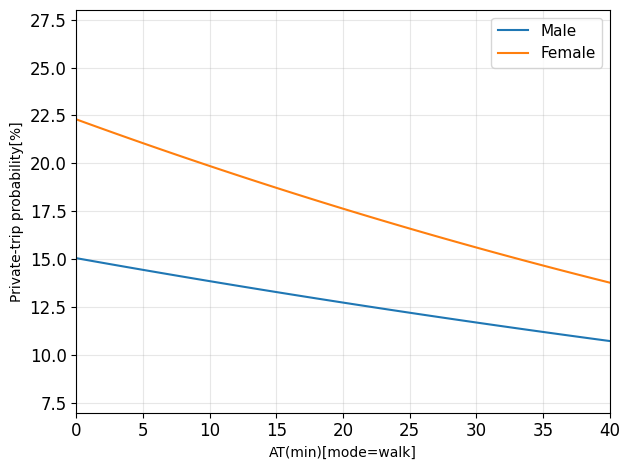

In [39]:
# 男女モデルによる端末時間の感度分析
# 固定値
work_time = master_df["WorkTime[m]"].mean() / 60          # 604分  hours
MACM_h    = master_df["MainlineTime[m]"].mean() / 60      # 56.1分 hours
AccessTime = master_df["AccessTime_used[m]"].mean()       # 10.5分
HHM = 2
lu  = 677535.273703768 / 1e6

# ロジスティクス関数の定義
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# パラメータ値の取得
beta_m = res_male.get_beta_values()
beta_f = res_female.get_beta_values()

# 端末時間の変動範囲
AT = np.arange(0, 40.0 + 0.5, 0.5)

def P_walk(beta, AT_array):
    V = (
        beta["ASC_YES"] 
        + beta["B_WORKTIME"] * work_time
        + beta["B_HHM_all"] * HHM
        + beta["B_N_EKI_SCORE"] * lu
        + beta["B_MACMTIME"] * MACM_h
        + beta["B_AT_WALK"] * AT_array
    )
    return logistic(V)

P_male = P_walk(beta_m, AT)
P_female = P_walk(beta_f, AT)

# 描画
plt.figure()
plt.plot(AT, P_male*100, label="Male")
plt.plot(AT, P_female*100, label="Female")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("AT(min)[mode=walk]")
plt.ylabel("Private-trip probability[%]")
plt.xlim(0, 40)
plt.ylim(7, 28)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [41]:
# 具体的な数値を算出
P_male_5 = P_walk(beta_m, 5)
P_male_15 = P_walk(beta_m, 15)
P_female_5 = P_walk(beta_f, 5)
P_female_15 = P_walk(beta_f, 15)
print("男性の端末時間の差", (P_male_5 - P_male_15)*100)
print("女性の端末時間の差", (P_female_5 - P_female_15)*100)

男性の端末時間の差 1.1572147839119973
女性の端末時間の差 2.32717968305044


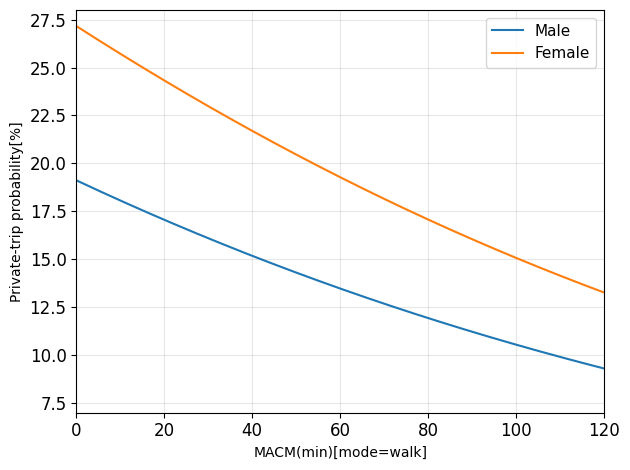

In [43]:
# 男女モデルによるメイン時間の感度分析
# 固定値
work_time = master_df["WorkTime[m]"].mean() / 60          # 604分  hours
MACM_h    = master_df["MainlineTime[m]"].mean() / 60      # 56.1分 hours
AccessTime = master_df["AccessTime_used[m]"].mean()       # 10.5分
HHM = 2
lu  = 677535.273703768 / 1e6

# ロジスティクス関数の定義
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# パラメータ値の取得
beta_m = res_male.get_beta_values()
beta_f = res_female.get_beta_values()

# 端末時間の変動範囲
MACM = np.arange(0, 120 + 0.5, 0.5)

def P_MACM(beta, MACM_array):
    V = (
        beta["ASC_YES"] 
        + beta["B_WORKTIME"] * work_time
        + beta["B_HHM_all"] * HHM
        + beta["B_N_EKI_SCORE"] * lu
        + beta["B_MACMTIME"] * (MACM_array/60)
        + beta["B_AT_WALK"] * AccessTime
    )
    return logistic(V)

P_male = P_MACM(beta_m, MACM)
P_female = P_MACM(beta_f, MACM)

# 描画
plt.figure()
plt.plot(MACM, P_male*100, label="Male")
plt.plot(MACM, P_female*100, label="Female")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("MACM(min)[mode=walk]")
plt.ylabel("Private-trip probability[%]")
plt.xlim(0, 120)
plt.ylim(7, 28)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [44]:
# 具体的な数値を算出
P_male_20 = P_MACM(beta_m, 20)
P_male_40 = P_MACM(beta_m, 40)
P_female_20 = P_MACM(beta_f, 20)
P_female_40 = P_MACM(beta_f, 40)
print("男性の端末時間の差", (P_male_20 - P_male_40)*100)
print("女性の端末時間の差", (P_female_20 - P_female_40)*100)

男性の端末時間の差 1.8790554235128931
女性の端末時間の差 2.6290308838955805


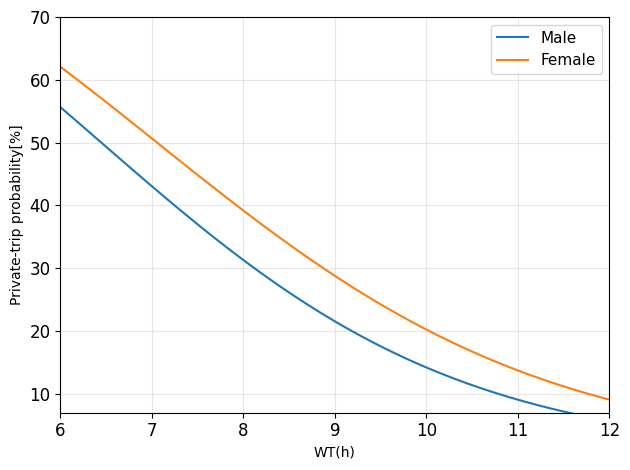

In [ ]:
# 男女モデルによる就業時間の感度分析
# 固定値
work_time = master_df["WorkTime[m]"].mean() / 60          # 604分  hours
MACM_h    = master_df["MainlineTime[m]"].mean() / 60      # 56.1分 hours
AccessTime = master_df["AccessTime_used[m]"].mean()       # 10.5分
HHM = 2
lu  = 677535.273703768 / 1e6

# ロジスティクス関数の定義
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# パラメータ値の取得
beta_m = res_male.get_beta_values()
beta_f = res_female.get_beta_values()

# 端末時間の変動範囲
WT = np.arange(6, 12 + 0.1, 0.1)

def P_Work(beta, WT_array):
    V = (
        beta["ASC_YES"] 
        + beta["B_WORKTIME"] * WT_array
        + beta["B_HHM_all"] * HHM
        + beta["B_N_EKI_SCORE"] * lu
        + beta["B_MACMTIME"] * MACM_h
        + beta["B_AT_WALK"] * AccessTime
    )
    return logistic(V)

P_male = P_walk(beta_m, WT)
P_female = P_walk(beta_f, WT)

# 描画
plt.figure()
plt.plot(WT, P_male*100, label="Male")
plt.plot(WT, P_female*100, label="Female")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("WT(h)")
plt.ylabel("Private-trip probability[%]")
plt.xlim(6, 12)
plt.ylim(7, 70)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()